In [1]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Define the SMILES string
smiles = "CCN(CC)c1ccc2oc(=O)c(C)nc2c1"

# Convert the SMILES string to a molecule
molecule = Chem.MolFromSmiles(smiles)

# Get the Murcko scaffold
scaffold = MurckoScaffold.GetScaffoldForMol(molecule)

# Convert the scaffold to a SMILES string
scaffold_smiles = Chem.MolToSmiles(scaffold)

print("Scaffold SMILES:", scaffold_smiles)

Scaffold SMILES: O=c1cnc2ccccc2o1


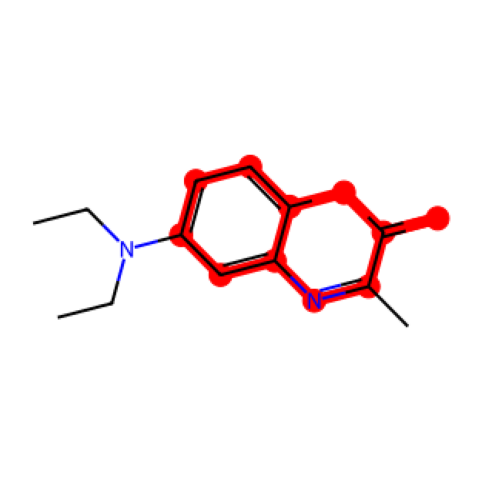

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
import matplotlib.pyplot as plt

def plot_molecule_with_scaffold(smiles):
    """
    Plots the molecule represented by a SMILES string, highlighting the scaffold in the figure.
    :param smiles: SMILES string of the molecule.
    """
    # Generate molecule and scaffold
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")
    
    # Generate the scaffold
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    if scaffold is None:
        raise ValueError(f"No scaffold found for SMILES: {smiles}")
    
    # Get atom and bond indices for the scaffold
    scaffold_indices = mol.GetSubstructMatch(scaffold)
    if not scaffold_indices:
        raise ValueError(f"Cannot match scaffold substructure in SMILES: {smiles}")
    
    # Highlight scaffold atoms and bonds
    atom_highlights = list(scaffold_indices)
    bond_highlights = []
    for bond in scaffold.GetBonds():
        start = scaffold_indices[bond.GetBeginAtomIdx()]
        end = scaffold_indices[bond.GetEndAtomIdx()]
        bond_idx = mol.GetBondBetweenAtoms(start, end).GetIdx()
        bond_highlights.append(bond_idx)
    
    # Draw the molecule with highlighted scaffold
    img = Draw.MolToImage(mol, highlightAtoms=atom_highlights, highlightBonds=bond_highlights, highlightColor=(1, 0, 0))
    
    # Create a figure and add the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Example usage
smiles = "CCN(CC)c1ccc2oc(=O)c(C)nc2c1"
plot_molecule_with_scaffold(smiles)

In [18]:
import csv
import pandas as pd
from welqrate.dataset import WelQrateDataset

# Load SMILES from CSV file
selected_smiles = pd.read_csv('sampled_smiles_AID1798_random_cv1_0.1.csv')
selected_smiles = selected_smiles['smiles'].tolist()

welqrate_dataset = WelQrateDataset(dataset_name='AID1798', root='./welqrate_datasets', mol_repr='2dmol')
original_smiles = welqrate_dataset.smiles

whole_smiles = original_smiles + selected_smiles
labels = ['original'] * len(original_smiles) + ['augmented'] * len(selected_smiles)


dataset stored in ./welqrate_datasets/AID1798
Dataset AID1798 loaded.
Number of active molecules: 164
Number of inactive molecules: 60542


In [8]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
sns.set_theme(rc={'figure.figsize': (10, 10)}, font_scale=1.5, style='whitegrid')


In [15]:
def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        mol = Chem.MolFromSmiles(smiles)
        fp_list.append(fp_as_array(mol,n_bits))
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,), np.int64)  # Changed from np.int to np.int64
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [16]:
fp_list = fp_list_from_smiles_list(whole_smiles)

100%|██████████| 64348/64348 [00:18<00:00, 3536.34it/s]


In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
crds = pca.fit_transform(fp_list) 

In [19]:
crds_df = pd.DataFrame(crds,columns=["PC_1","PC_2"])
crds_df['label'] = list(labels)
crds_df.head()

,PC_1,PC_2,label
0,-0.166869,0.851911,original
1,-0.286441,0.316088,original
2,0.331926,-0.588644,original
3,-1.456542,-0.016376,original
4,0.519454,-0.534312,original


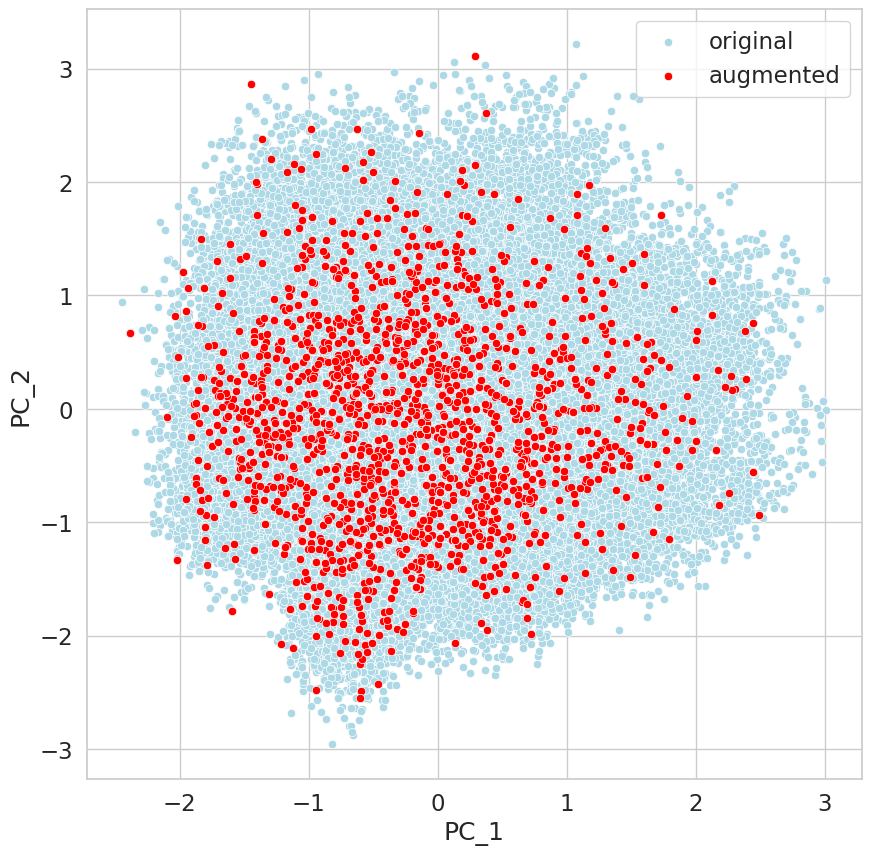

In [20]:
ax = sns.scatterplot(data=crds_df.query("label == 'original'"),x="PC_1",y="PC_2",color='lightblue')
ax = sns.scatterplot(data=crds_df.query("label == 'augmented'"),x="PC_1",y="PC_2",color='red')
_ = plt.legend(labels=['original', 'augmented'])

